# Hands on Spectrum analysis

In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy
print('numpy:', np.__version__)
print('astropy:', astropy.__version__)

numpy: 1.23.2
astropy: 5.1


In [3]:
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from astropy.io import fits, ascii

import glob

To open the fits file we use `fits.open()` and just specify the filename as an argument:

In [4]:
fits_file = fits.open('../../data/ngc1275/magic/20170101_05059487_DL3_NGC1275-W0.40+157.fits')

We can retrieve some basic information on the  header data unit (HDU) by calling `.info()`:

In [5]:
ascii.read?

Signature: ascii.read(table, guess=None, **kwargs)
Docstring:
Read the input ``table`` and return the table.  Most of
the default behavior for various parameters is determined by the Reader
class.

See also:

- https://docs.astropy.org/en/stable/io/ascii/
- https://docs.astropy.org/en/stable/io/ascii/read.html

Parameters
----------
table : str, file-like, list, `pathlib.Path` object
    Input table as a file name, file-like object, list of string[s],
    single newline-separated string or `pathlib.Path` object.
guess : bool
    Try to guess the table format. Defaults to None.
format : str, `~astropy.io.ascii.BaseReader`
    Input table format
Inputter : `~astropy.io.ascii.BaseInputter`
    Inputter class
Outputter : `~astropy.io.ascii.BaseOutputter`
    Outputter class
delimiter : str
    Column delimiter string
comment : str
    Regular expression defining a comment line in table
quotechar : str
    One-character string to quote fields containing special characters
header_start : int

In [181]:
table = ascii.read('untitled.txt', delimiter=' ', names=['c1','c2','c3'])

In [182]:
table

c1,c2,c3
int64,int64,int64
2,1,2
1,2,4


In [180]:
type(table)

astropy.table.table.Table

In [106]:
fits_file.info()

Filename: ../../data/pks2155/hess/hess_dl3_dr1_obs_id_033795.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  EVENTS        1 BinTableHDU     77   10589R x 5C   [1K, 1D, 1E, 1E, 1E]   
  2  GTI           1 BinTableHDU     32   1R x 2C   [1D, 1D]   
  3  AEFF          1 BinTableHDU     47   1R x 5C   [96E, 96E, 6E, 6E, 576E]   
  4  EDISP         1 BinTableHDU     43   1R x 7C   [96E, 96E, 160E, 160E, 6E, 6E, 92160E]   
  5  PSF           1 BinTableHDU     48   1R x 7C   [32E, 32E, 6E, 6E, 144E, 144E, 27648E]   


### Events

In [6]:
events = fits_file['EVENTS']

In [7]:
events.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   40 / width of table in bytes                        
NAXIS2  =                12614 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    8 / number of fields in each row                   
TTYPE1  = 'EVENT_ID'           / label for field   1                            
TFORM1  = '1K      '           / data format of field: 8-byte INTEGER           
TTYPE2  = 'TIME    '           / label for field   2                            
TFORM2  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT2  = 's       '        

### PLOT SOURCE, POINTING and ON and OFF REGIONS

In [8]:
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.wcs import WCS

First we get the pointing postion of the telescope

In [9]:
pointing_pos =  SkyCoord( events.header.get('RA_PNT') *u.deg,   events.header.get('DEC_PNT') *u.deg )
pointing_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (49.45417, 41.66806)>

Then the postion of the source on the sky

In [10]:
source_name = events.header.get('OBJECT')
print(source_name)
source_pos   =  SkyCoord.from_name(events.header.get('OBJECT'))
source_pos

NGC1275


<SkyCoord (ICRS): (ra, dec) in deg
    (49.95066567, 41.51169838)>

As you can see the 2 position are not the same (Why?) 

let's compute the offset

In [11]:
offset = source_pos.separation(pointing_pos)
offset.to( u.deg).value

0.4029134639574329

We now compute the angle between the source and the pointing position.

If for instance the two are aligned along a meridian, the angle would be of 0 or 180 degrees, depending on which position one uses as a reference

Let's see it in detail:

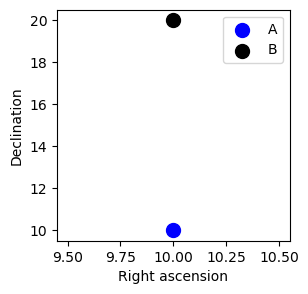

In [134]:
A =  SkyCoord( ra= 10 *u.deg,   dec = 10 *u.deg )
B =  SkyCoord( ra= 10 *u.deg,   dec = 20 *u.deg )

fig, ax =  plt.subplots(figsize=(3,3))

ax = plt.subplot()
ax.scatter(A.ra.value, A.dec.value, marker='o', s=100, c='blue', label ='A'  ) 
ax.scatter(B.ra.value, B.dec.value, marker='o', s=100, c='black', label ='B'  ) 
ax.set_xlabel('Right ascension')
ax.set_ylabel('Declination')
ax.legend();

In [135]:
A.position_angle(B).to(u.degree)

<Angle 0. deg>

The angle between A and B is zero!

In [136]:
B.position_angle(A).to(u.degree)

<Angle 180. deg>

The angle between A and B is instead 180

Excercise:
- Try different position for A and B and get the angle

Let's do this now for the source and pointing position

In [13]:
source_angle = pointing_pos.position_angle(source_pos).to(u.degree)
source_angle

<Angle 112.6699536 deg>

The angle is approximately 180+45 degree, meaning that the source is located on the 'left-bottom' part of the sky, relative to the pointing

Indeed:

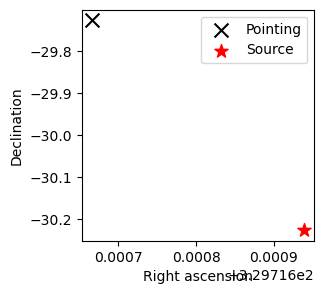

In [138]:
fig, ax =  plt.subplots(figsize=(3,3))

ax = plt.subplot()
ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 
ax.set_xlabel('Right ascension')
ax.set_ylabel('Declination')
ax.legend();

Let's now compute the angles for the off positions

In [14]:
off1_angle   = source_angle + 90*u.deg
off2_angle   = off1_angle   + 90*u.deg
off3_angle   = off2_angle   + 90*u.deg

Given the above angles, we now put the off positions on the same offset from the pointing that was used for the source

In [15]:
off1_pos = pointing_pos.directional_offset_by(position_angle=off1_angle, separation=offset)  
off2_pos = pointing_pos.directional_offset_by(position_angle=off2_angle, separation=offset)  
off3_pos = pointing_pos.directional_offset_by(position_angle=off3_angle, separation=offset) 

We can now see the results

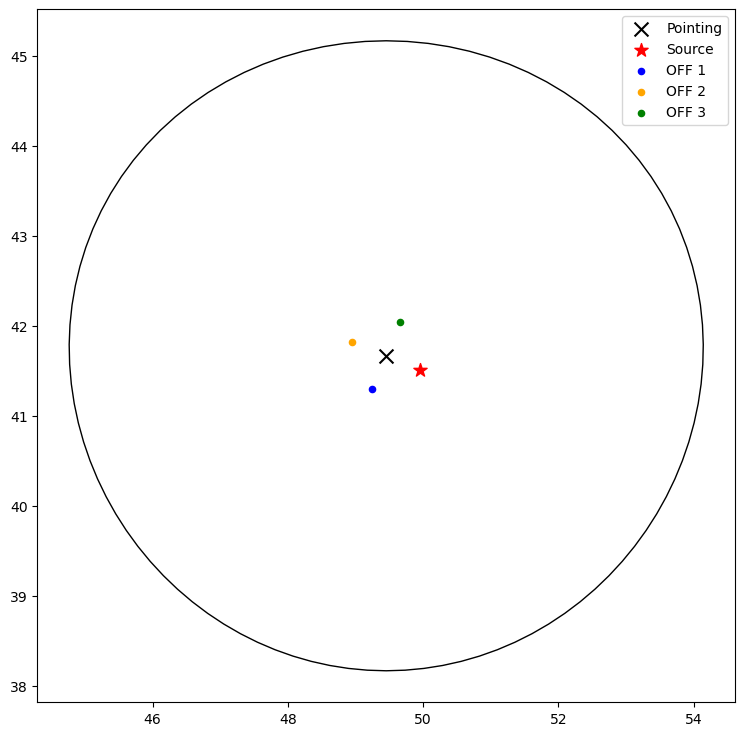

In [16]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = plt.subplot()


field_of_view = SphericalCircle( (pointing_pos.ra, pointing_pos.dec),
                    3.5 * u.deg,   edgecolor='black', facecolor='none')

ax.add_patch(field_of_view)

ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 
ax.scatter(off1_pos.ra.value, off1_pos.dec.value, marker='o', s=20, c='blue', label ='OFF 1'  ) 
ax.scatter(off2_pos.ra.value, off2_pos.dec.value, marker='o', s=20, c='orange', label ='OFF 2'  ) 
ax.scatter(off3_pos.ra.value, off3_pos.dec.value, marker='o', s=20, c='green', label ='OFF 3'  ) 
ax.legend(loc='upper right');

Or even better we can plot the On and Off regions

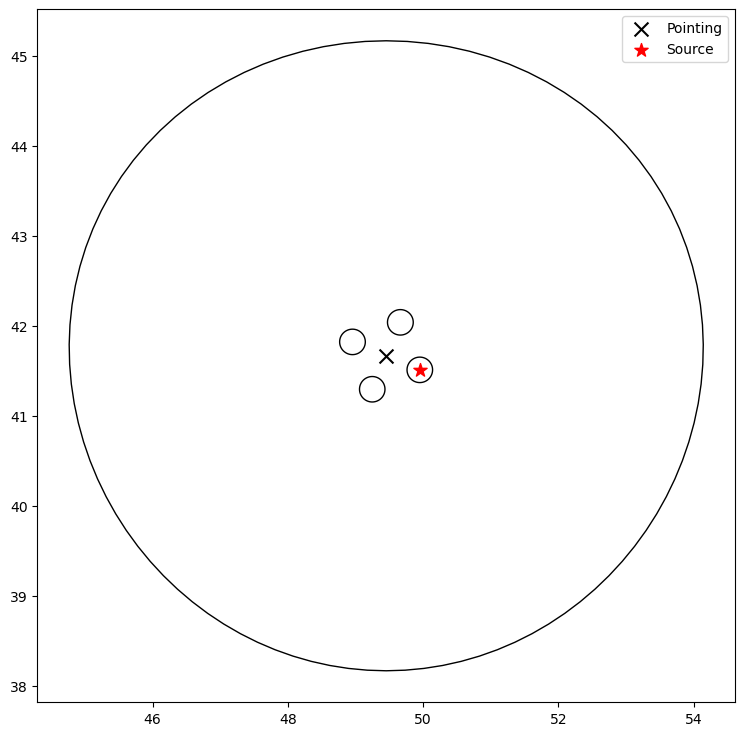

In [17]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = plt.subplot()




field_of_view = SphericalCircle( (pointing_pos.ra, pointing_pos.dec),
                    3.5 * u.deg,   edgecolor='black', facecolor='none')

radius = 0.1414213*u.deg

on  = SphericalCircle( (source_pos.ra, source_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

off1 = SphericalCircle( (off1_pos.ra, off1_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off2 = SphericalCircle( (off2_pos.ra, off2_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off3 = SphericalCircle( (off3_pos.ra, off3_pos.dec),
                    radius,   edgecolor='black', facecolor='none')


ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 

ax.add_patch(field_of_view)

ax.add_patch(on)
ax.add_patch(off1)
ax.add_patch(off2)
ax.add_patch(off3)


ax.legend();

### PLOT AZIMUTH AND ALTITUDE DURING THE OBSERVATION

This is not necessary for the analysis, but it is interesting to see how the altitude and azimuth of the source evolves during the observation

In [18]:
from astropy.coordinates import EarthLocation, AltAz
from astropy.time import Time

In [19]:
ROM = EarthLocation( lat=events.header.get('GEOLAT')* u.deg, 
              lon=events.header.get('GEOLON') * u.deg, 
              height= events.header.get('ALTITUDE')*u.m)
print(ROM.geodetic)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'Unit'

In [145]:
start_time = Time( events.header.get('DATE-OBS') +'T'+events.header.get('TIME-OBS')) 
end_time   = Time( events.header.get('DATE-END') +'T'+events.header.get('TIME-END')) 

In [146]:
start_time

<Time object: scale='utc' format='isot' value=2006-07-30T00:36:58.184>

In [147]:
dt = ( end_time - start_time ) /100
times        = []
source_altaz = []
for i in range(100):
    time        = start_time + dt*i
    altaz        = AltAz(obstime=time, location=ROM)
    i_source_altaz = source_pos.transform_to(altaz)
    times.append( time )
    source_altaz.append( i_source_altaz )
    

In [148]:
all_alt = [  i.alt.value for i in source_altaz ]
all_az  = [  i.az.value  for i in source_altaz ]

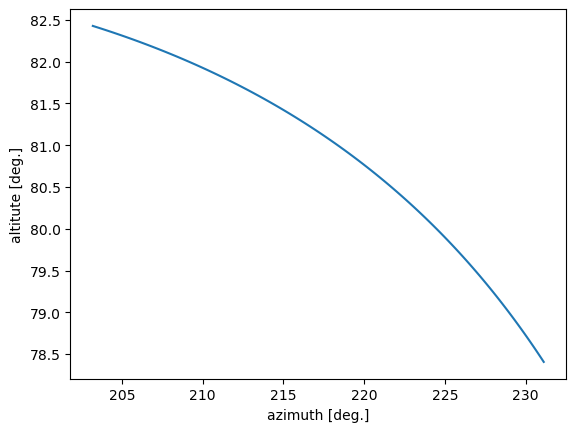

In [149]:
plt.plot(  all_az, all_alt)
plt.xlabel( "azimuth [deg.]")
plt.ylabel( "altitute [deg.]");

## GET EVENTS

We save the evtns as an Astropy Table

In [20]:
events_table = Table( events.data )
events_table

EVENT_ID,TIME,RA,DEC,ENERGY,GAMMANESS,DETX,DETY
int64,float64,float32,float32,float32,float32,float32,float32
117,436139121.599158,49.01414,41.539272,0.10293761,0.9410159,0.3199254,-0.13709812
138,436139121.66326886,48.04316,42.417595,0.06289925,0.41138095,1.0475081,0.7366911
210,436139121.89286935,49.00081,41.941536,0.040962473,0.24814683,0.33467507,0.2649405
233,436139121.9688521,48.99533,41.803627,0.034511823,0.32546824,0.33711714,0.12696764
337,436139122.25264156,49.906765,42.391163,0.05785944,0.7387659,-0.32914373,0.7258594
355,436139122.2984954,50.021763,41.50761,0.29707232,0.8527024,-0.43491018,-0.15557902
364,436139122.31179434,49.556606,41.83252,0.115851775,0.78795886,-0.08073081,0.16200143
...,...,...,...,...,...,...,...
365,436140309.13955593,48.90019,39.938328,0.07041095,0.8203301,0.9340612,-1.5122926


We then plot them "on the Sky" using the information on the RA and DEC of each single event

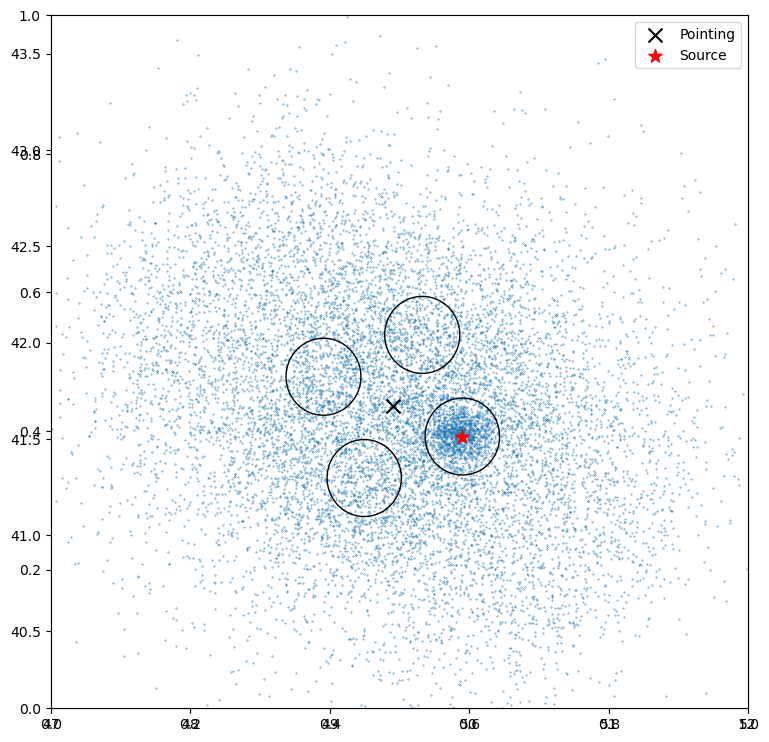

In [70]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = fig.add_subplot()

ra =    events_table['RA'] * u.deg  

dec = events_table['DEC']*u.deg

ax.scatter(ra, dec, s=0.1)


radius = 0.2*u.deg

on  = SphericalCircle( (source_pos.ra, source_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

off1 = SphericalCircle( (off1_pos.ra, off1_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off2 = SphericalCircle( (off2_pos.ra, off2_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off3 = SphericalCircle( (off3_pos.ra, off3_pos.dec),
                    radius,   edgecolor='black', facecolor='none')


ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 

ax.add_patch(on)
ax.add_patch(off1)
ax.add_patch(off2)
ax.add_patch(off3)

ax.set_xlim([47,52])
ax.set_ylim([40.1,43.7])


ax.legend();

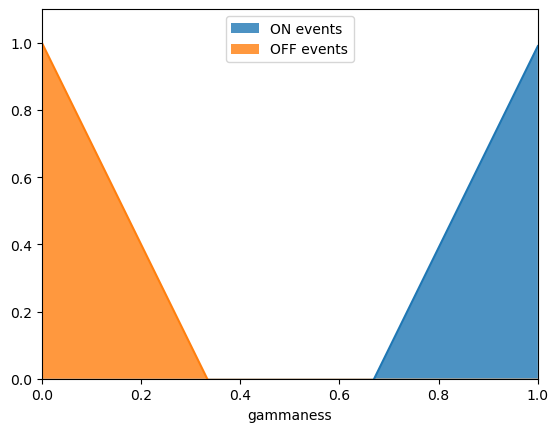

In [109]:
x = np.linspace(0,1,1000)

y = (x-0.67)*3
plt.plot(x,y)
plt.fill_between(x, y, y2=0, label='ON events',alpha=0.8)

y = 1-x*3
plt.plot(x,y)
plt.fill_between(x, y, y2=0, label='OFF events',alpha=0.8)
plt.xlim([0,1])
plt.ylim([0,1.1])
plt.xlabel('gammaness')

plt.legend(loc='upper center')

As expected we have more events near the Source!

As one can see from the OFF regions, some of these events are not gamma-rays, but background

Rember that in the Off region we should not expect any gamma-ray

### EVENTS SELECTION

We now select the events in the 4 regions: 1 ON and 3 OFF

In [22]:
ra = events_table['RA'] 
dec = events_table['DEC']

radius = 0.2*u.deg 

cond_on = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_on.append( source_pos.separation(position_event) <= radius )
    
cond_off1 = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_off1.append( off1_pos.separation(position_event) <= radius )
    
cond_off2 = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_off2.append( off2_pos.separation(position_event) <= radius )
    

cond_off3 = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_off3.append( off3_pos.separation(position_event) <= radius )
    
    

Let's plot the events we have selected

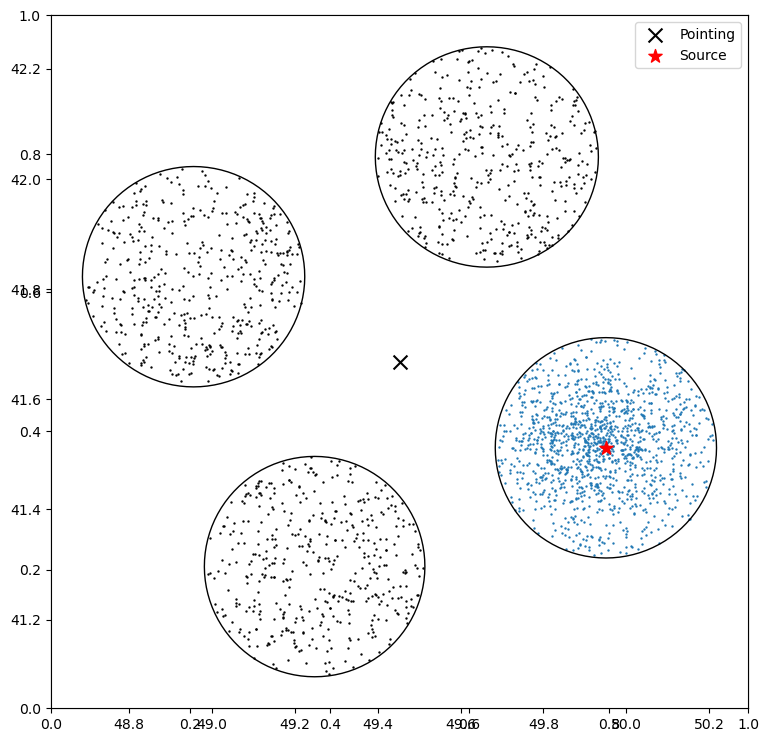

In [23]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = fig.add_subplot()

ra = events_table[cond_on]['RA']
dec = events_table[cond_on]['DEC']
ax.scatter(ra, dec, s=0.5)

ra = events_table[cond_off1]['RA'] 
dec = events_table[cond_off1]['DEC']
ax.scatter(ra, dec, s=0.5, c ='black')

ra = events_table[cond_off2]['RA'] 
dec = events_table[cond_off2]['DEC']
ax.scatter(ra, dec, s=0.5,  c ='black')

ra = events_table[cond_off3]['RA'] 
dec = events_table[cond_off3]['DEC']
ax.scatter(ra, dec, s=0.5,  c ='black')



ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 

radius = 0.2*u.deg

on  = SphericalCircle( (source_pos.ra, source_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

off1 = SphericalCircle( (off1_pos.ra, off1_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off2 = SphericalCircle( (off2_pos.ra, off2_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off3 = SphericalCircle( (off3_pos.ra, off3_pos.dec),
                    radius,   edgecolor='black', facecolor='none')


ax.add_patch(on)
ax.add_patch(off1)
ax.add_patch(off2)
ax.add_patch(off3)



ax.legend();

In [45]:
theta2_on = []

ra = events_table['RA'][cond_on]
dec = events_table['DEC'][cond_on]


for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    theta2_on.append( source_pos.separation(position_event)**2)


theta2_off = []

ra = events_table['RA'][cond_off1]
dec = events_table['DEC'][cond_off1 ]

for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    theta2_off.append( off1_pos.separation(position_event)**2)
    
ra = events_table['RA'][cond_off2]
dec = events_table['DEC'][cond_off2 ]

for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    theta2_off.append( off2_pos.separation(position_event)**2)
    

ra = events_table['RA'][cond_off3]
dec = events_table['DEC'][cond_off3 ]

for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    theta2_off.append( off3_pos.separation(position_event)**2)
    


Text(0.5, 0, '$\\theta^2$')

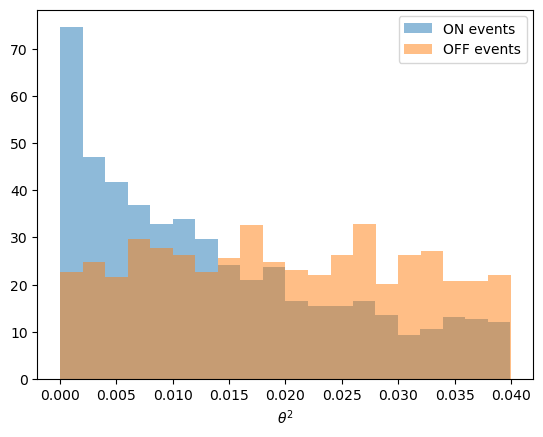

In [51]:
plt.hist(theta2_on,bins=20,density=True,alpha=0.5,label='ON events');
plt.hist(theta2_off,bins=20,density=True,alpha=0.5, label='OFF events');
plt.legend();
plt.xlabel(r'$\theta^2$')

Text(0.5, 0, 'Gammaness')

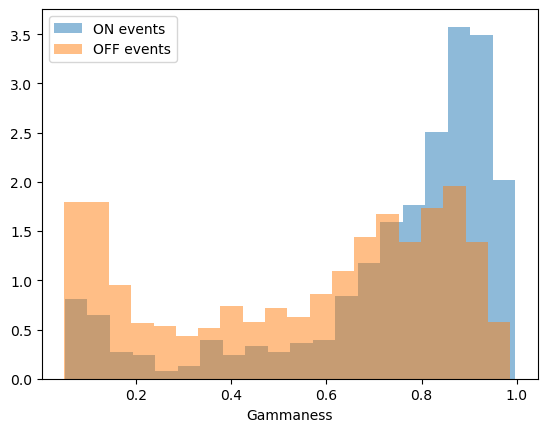

In [56]:
gammaness_on = events_table['GAMMANESS'][cond_on]

gammaness_off = events_table['GAMMANESS'][np.array(cond_off1)+np.array(cond_off2)+np.array(cond_off3)]

plt.hist(gammaness_on,bins=20,density=True,alpha=0.5,label='ON events');
plt.hist(gammaness_off,bins=20,density=True,alpha=0.5, label='OFF events');
plt.legend();
plt.xlabel(r'Gammaness')

### Effective Area

for computing the Flux we need the Effective Area and the exposure time

In [159]:
eff_area = fits_file['AEFF']

In [160]:
eff_area.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3120 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
EXTNAME = 'AEFF    '           / name of this binary table extension            
CREF5   = '(ENERG_LO:ENERG_HI,THETA_LO:THETA_HI)'                               
HDUCLASS= 'GADF    '                                                            
HDUDOC  = 'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'    
HDUVERS = '0.2     '        

In [161]:
exposure_time = events.header.get('LIVETIME') * u.second 
exposure_time.to( u.minute)

<Quantity 26.05043945 min>

It's better to work with an Astropy table

In [162]:
effective_area = Table( eff_area.data)
effective_area

ENERG_LO,ENERG_HI,THETA_LO,THETA_HI,EFFAREA
float32[96],float32[96],float32[6],float32[6],"float32[6,96]"
0.01 .. 90.85179,0.011006941 .. 100.0,0.0 .. 2.5,0.0 .. 2.5,0.0 .. 151892.47


In [163]:
effective_area['EFFAREA'].value

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.74827031e+04, 2.87979707e+04, 3.91062266e+04,
         4.89471211e+04, 5.79140586e+04, 6.66445781e+04, 7.38602344e+04,
         8.05796641e+04, 8.76436172e+04, 9.41125781e+04, 1.00752695e+05,
         1.07684984e+05, 1.15666477e+05, 1.23398414e+05, 1.31517297e+05,
         1.39977391e+05, 1.49505078e+05, 1.58400266e+05, 1.67320359e+05,
         1.76124219e+05, 1.85420500e+05, 1.93498797e+05, 2.01007125e+05,
         2.07819250e+05, 2.14334484e+05, 2.19384531

We get from the table the enrgy bins and the value ofthe Area for each bin

In [164]:
theta_low  = np.array( effective_area['THETA_LO'] )[0]
theta_high = np.array( effective_area['THETA_HI'] )[0]

en_low     = np.array( effective_area['ENERG_LO'] )[0]
en_high    = np.array( effective_area['ENERG_HI'] )[0]
en_center = np.sqrt( en_low * en_high )
delta_E  = (en_high - en_low)

eff_area   = np.array( effective_area['EFFAREA'] )[0][0]



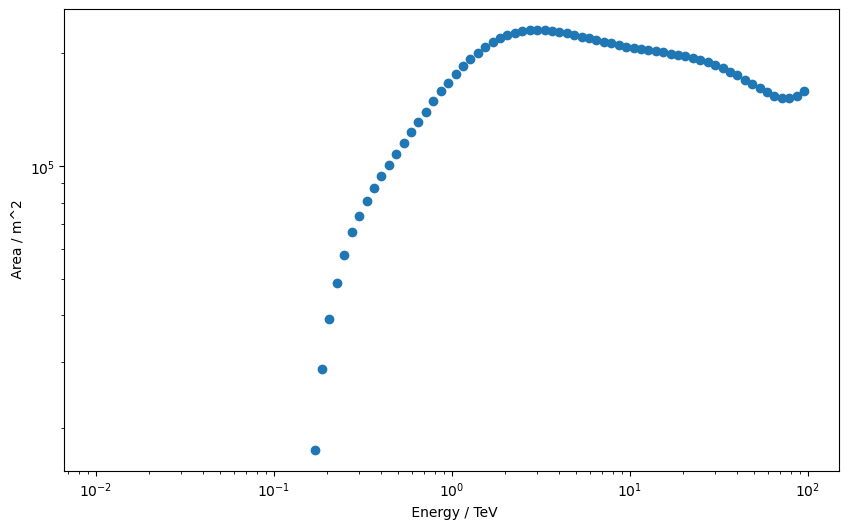

In [165]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)

ax.scatter(en_center,  eff_area)


ax.set_xlabel( ' Energy / TeV')
ax.set_ylabel( ' Area / m^2')
ax.set_xscale('log')
ax.set_yscale('log')

 WE REMOVE BIN WITH EFF AREA = 0

In [72]:
cond = eff_area >0
en_center = en_center[cond]
en_low    = en_low[cond]
en_high   = en_high[cond]
delta_E    = delta_E[cond]

eff_area  = eff_area[cond]

### COMPUTE EXCESS

We are now ready to compute the ON counts, OFF counts and the excess in each energy bin

In [168]:
#1

In [89]:
excess = [] 
err_excess = []

noff_list = []
non_list  = []

for i_en_low, i_en_high in zip( en_low, en_high):
    cond_low  = events_table['ENERGY'] >= i_en_low
    cond_high = events_table['ENERGY']  < i_en_high
    cond_en   = cond_low* cond_high
    
    non    = np.sum( cond_en*cond_on)
    
    noff   = np.sum( cond_en*cond_off1) +\
             np.sum( cond_en*cond_off2) +\
             np.sum( cond_en*cond_off3) 
    
    noff_list.append(noff)
    non_list.append(non)
    
    excess.append( non - noff/3 )
    err_excess.append( np.sqrt( non + (1/3)**2*noff) )
    
excess     = np.array(excess)
err_excess = np.array(err_excess)

non_list   = np.array(non_list)
noff_list   = np.array(noff_list)

In [104]:
err_excess

array([ 1.        ,  7.08676388, 10.78064109,  9.8319208 ,  8.47217668,
        9.20144916,  6.52346193,  5.88784058,  3.        ,  3.        ,
        1.73205081,  1.41421356])

In [91]:
non_list

array([  0,   1,  40, 101,  90,  69,  83,  42,  34,   9,   9,   3,   2,
         0,   0,   0])

In [92]:
noff_list

array([  0,   0,  92, 137,  60,  25,  15,   5,   6,   0,   0,   0,   0,
         0,   0,   0])

Why did I put in the loop `non - noff/3` and not another number like for instance  `non - noff/5` ?

Total Non events in each energy bin

In [95]:
print(non_list)

[  0   1  40 101  90  69  83  42  34   9   9   3   2   0   0   0]


Total Noff events in each energy bin

In [96]:
print(noff_list)

[  0   0  92 137  60  25  15   5   6   0   0   0   0   0   0   0]


Excess in each energy bin

In [97]:
print(excess)

[ 0.          1.          9.33333333 55.33333333 70.         60.66666667
 78.         40.33333333 32.          9.          9.          3.
  2.          0.          0.          0.        ]


Excercise
- Compute the Li&Ma significance for each energy bin using the value of Non and Noff computed (remeber that we are also using $\alpha$ = 1/3)

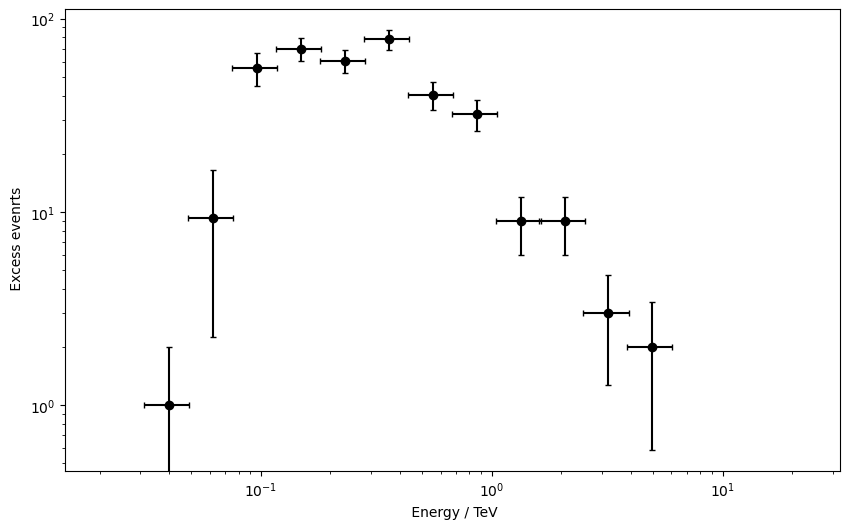

In [98]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=en_center, y=excess, yerr=err_excess , xerr = delta_E/2 , c='black', capsize=2, fmt='o')

ax.set_xlabel( ' Energy / TeV')
ax.set_ylabel( ' Excess evenrts')
ax.set_xscale('log')
ax.set_yscale('log')

WE THE REMOVE BIN WITH NEGATIVE OR ZERO EXCESS

In [99]:
cond = excess >0
en_center = en_center[cond]
en_low    = en_low[cond]
en_high   = en_high[cond]
delta_E    = delta_E[cond]

eff_area  = eff_area[cond]

excess     = excess[cond]
err_excess = err_excess[cond]

noff_list = noff_list[cond]
non_list  = non_list[cond]

### COMPUTE FLUX

We are now finally ready to compute the flux in each energy bin

In [100]:
flux = excess/( eff_area * u.m**2)/ exposure_time/ ( delta_E *u.TeV)

flux_err = err_excess/( eff_area * u.m**2)/ exposure_time/ ( delta_E *u.TeV)


We can now plot the flux in energy

For reference we will also print the flux we should expect from the Crab Nebula

In [102]:
def log_parababola( e, f0, E0, a, b):
    return f0* (e/E0) **( - a + b* np.log( e/E0))

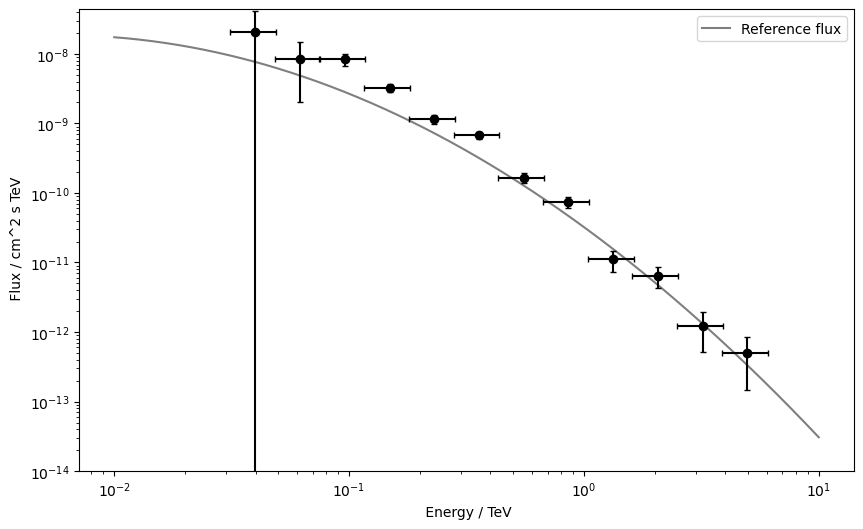

In [103]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=en_center, 
            y=flux.to( 1/(u.TeV * u.cm**2 * u.s) ).value, 
            yerr = flux_err.to( 1/(u.TeV * u.cm**2 * u.s) ).value , 
            xerr = delta_E/2 , c='black', capsize=2, fmt='o')

x = np.logspace(-2,1,1000) * u.TeV
f0 = 3.23e-11 * 1/(u.TeV * u.cm**2 * u.s)
E0 = 1 * u.TeV
a  = 2.47
b  = -0.24
y = log_parababola(x, f0, E0, a, b)

ax.plot(x,y, c='black', alpha=0.5,label='Reference flux')

ax.set_ylim([1e-14, None])

ax.set_xlabel( ' Energy / TeV')

ax.set_ylabel( ' Flux / cm^2 s TeV')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();

# SED WITH GAMMAPY 

In [ ]:
import gammapy
import gammapy.irf as irf
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation, Observations, DataStore

from gammapy.maps import MapAxis, WcsGeom, Map, RegionGeom
from gammapy.makers import SafeMaskMaker, MapDatasetMaker, SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker, WobbleRegionsFinder
from gammapy.estimators import FluxPointsEstimator

import regions
from regions import CircleSkyRegion, PointSkyRegion

from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    GaussianSpatialModel,
    TemplateSpatialModel,
    FoVBackgroundModel,
    SpectralModel,
    #Parameter, 
    TemplateSpectralModel
)
# dataset modules
from gammapy.datasets import (
    MapDataset, 
    MapDatasetOnOff, 
    MapDatasetEventSampler,
    SpectrumDatasetOnOff,
    SpectrumDataset, 
    Datasets,
    FluxPointsDataset
)

from gammapy.visualization import plot_spectrum_datasets_off_regions

For loading 
- Crab Nebula ( MAGIC , VERITAS)
- Mrk421 (MAGIC)
- NGC1275 (MAGIC)
- IC310 (MAGIC)
- PKS 2155-304 (HESS, but use second method)

In [ ]:
observations_crab = Observations()
for filename in glob.glob(f"../../data/crab_nebula/magic/*fits"):
    observations_crab.append(Observation.read(filename))

For loading 
- Crab Nebula ( FACT,  HESS, but use second method)

In [ ]:
datastore = DataStore.from_dir(f"../../data/crab_nebula/hess/")

observations_crab = datastore.get_observations(
    required_irf=["aeff", "edisp"]
)

#obs_ids = [5029747,5029748 ]
#obs_ids = [54809,57993 ]
#obs_ids = [5059487,5059488]
#observations_crab = datastore.get_observations(obs_ids, required_irf='point-like')

Define poston of the source target

Chosse the one you are analyzing

In [ ]:
target_position =SkyCoord.from_name('NGC1275')

In [ ]:
target_position = SkyCoord.from_name('Mrk421')

In [ ]:
target_position = SkyCoord.from_name('IC310')

In [ ]:
target_position = SkyCoord.from_name('PKS 2155-304')

In [ ]:
target_position = SkyCoord(ra=83.63, dec=22.0145, unit="deg", frame="icrs")

Energy axes

In [ ]:
energy_axis = MapAxis.from_energy_bounds(
    0.03204001, 6.185958, nbin=12, per_decade=False, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
   0.01, 10, nbin=12, per_decade=False, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(
    energy_axis_true=energy_axis_true, geom=geom
)


### Dataset creation

In [ ]:
#Number of off regions to be used to estimate the background
on_center = PointSkyRegion(target_position)
geom = RegionGeom.create(region=on_center, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(
    energy_axis_true=energy_axis_true, geom=geom
)


n_off_regions = 3
region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

emin             = 80*u.GeV
emax             = 2.1*u.TeV
datasets = Datasets()
for obs in observations_crab:
    dataset = dataset_maker.run(dataset_empty.copy(name=f"{obs.obs_id}"), obs)
    dataset.mask_fit = dataset.counts.geom.energy_mask(emin, emax)
    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off.mask_fit = dataset_on_off.counts.geom.energy_mask(emin, emax)
    datasets.append(dataset_on_off)

### Dataset creation with second method

In [ ]:
# for FACT Crab Nebula
#theta = observations_crab[0].aeff.meta['RAD_MAX']
#assert all(o.aeff.meta['RAD_MAX'] == theta for o in observations_crab)

# for HESS PKS and Crab Nebula
theta = 0.1

on_region_radius = Angle(theta*u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

skydir = target_position.galactic

In [ ]:
%%time

dataset_maker = SpectrumDatasetMaker(
     selection=["counts", "exposure","edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(
                                            min_distance="45 deg",
                                            min_distance_input="5 deg",
                                           max_region_number=3)


datasets = Datasets()

#for obs_id, observation in zip(obs_ids, observations_crab):
for observation in observations_crab:

    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(observation.obs_id)), observation
    )
    dataset_on_off = bkg_maker.run(dataset
                                   , observation)

    datasets.append(dataset_on_off)

### Flux computation

In [ ]:
gammapy_on         = dataset_on_off.counts.data.flatten()
gammapy_off        = dataset_on_off.counts_off.data.flatten()
gammapy_excess     = dataset_on_off.excess.data.flatten()
gammapy_excess_err = np.sqrt(gammapy_on + gammapy_off*(1/3)**2)

For consistency and comparison with the previous results, we are going to use the same energy edges

In [ ]:
energy_edges= np.array( [ 0.03204001, 0.04967855, 0.07702737, 0.11943215, 0.18518144,
       0.28712675, 0.44519454, 0.69028115, 1.0702919 , 1.6595044 ,
       2.5730877 , 3.989613 , 6.185958]) * u.TeV

In [ ]:
spectral_model = ExpCutoffPowerLawSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2,
    lambda_=0.1 * u.Unit("TeV-1"),
    reference=1 * u.TeV,
)
model = SkyModel(spectral_model=spectral_model, name="crab")

datasets.models = [model]

fit = Fit()
result = fit.run(datasets=datasets)

In [ ]:
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source='crab', selection_optional="all"
)

In [ ]:
gammapy_flux = []
gammapy_flux_err = []

for energy_min, energy_max in zip(fpe.energy_edges[:-1], fpe.energy_edges[1:]):
    print(energy_min)
    row = fpe.estimate_flux_point(
        datasets,
        energy_min=energy_min,
        energy_max=energy_max,
    )
    gammapy_flux.append(row['ref_dnde'].value)

# COMPARISON GAMMAPY AND ASTROPY

In [ ]:

fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)

ax.errorbar(x=en_center, y=excess, yerr=err_excess , xerr = delta_E/2 , c='black', capsize=2, fmt='o', label='Astropy')
ax.errorbar(x=en_center, y=gammapy_excess, yerr=gammapy_excess_err , xerr = delta_E/2 , c='blue', capsize=2, fmt='o',alpha=0.5, label='Gammapy')

ax.set_xlabel( ' Energy / TeV')
ax.set_ylabel( ' Counts')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Excess ')
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)

ax.errorbar(x=en_center, y=non_list, yerr=np.sqrt(non_list) , xerr = delta_E/2 , c='black', capsize=2, fmt='o', label='Astropy')
ax.errorbar(x=en_center, y=gammapy_on, yerr=np.sqrt(gammapy_on) , xerr = delta_E/2 , c='blue',  alpha=0.5,capsize=2, fmt='o', label='Gammapy')

ax.set_xlabel( ' Energy / TeV')
ax.set_ylabel( ' Counts')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('ON ')
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)

ax.errorbar(x=en_center, y=noff_list, yerr=np.sqrt(noff_list) , xerr = delta_E/2 , c='black', capsize=2, fmt='o', label='Astropy')
ax.errorbar(x=en_center, y=gammapy_off, yerr=np.sqrt(gammapy_off) , xerr = delta_E/2 , c='blue',  alpha=0.5,capsize=2, fmt='o', label='Gammapy')

ax.set_xlabel( ' Energy / TeV')
ax.set_ylabel( ' Counts')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('OFF ')
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=en_center, 
            y=flux.to( 1/(u.TeV * u.cm**2 * u.s) ).value, 
            yerr = flux_err.to( 1/(u.TeV * u.cm**2 * u.s) ).value , 
            xerr = delta_E/2 , c='black', capsize=2, fmt='o', label='Astropy')

ax.errorbar(x=en_center, 
            y=gammapy_flux, 
            yerr = 0 , 
            xerr = delta_E/2 , c='blue', capsize=2, fmt='o',label='Gammapy - Unfolded')


x = np.logspace(-2,1,1000) * u.TeV
f0 = 3.23e-11 * 1/(u.TeV * u.cm**2 * u.s)
E0 = 1 * u.TeV
a  = 2.47
b  = -0.24
y = log_parababola(x, f0, E0, a, b)

ax.plot(x,y, c='black', alpha=0.5,label='Reference flux')

ax.set_ylim([1e-13, None])

ax.set_xlabel( ' Energy / TeV')

ax.set_ylabel( ' Flux / cm^2 s TeV')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();